In [167]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

In [168]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.acquisition.active_learning import PairwiseMCPosteriorVariance
from botorch.acquisition.analytic import PosteriorStandardDeviation

from botorch.models.gp_regression import HeteroskedasticSingleTaskGP # This implements the variance of the y
from botorch.utils.transforms import normalize
from botorch.utils.transforms import unnormalize

## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
# botorch.optim.optimize.optimize_acqf_mixed
from botorch.optim import optimize_acqf_mixed


In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


In [170]:
def scatter_results(data,mean,var):
    x_values = data
    y_values = mean.numpy().squeeze()
    yvar_values = var.numpy().squeeze()
    # Define the pairs of features to plot
    feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    #lev = np.linspace(0.0,1.0,100)
    # Create contour plots for each pair of features
    plt.figure(figsize=(14, 9))
    for i, (f1, f2) in enumerate(feature_pairs):
        # Extract the pair of features
        x_pair = x_values[:, [f1, f2]].numpy()
        
        # Plot the contour plot
        plt.subplot(2, 3, i + 1)
        plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values, cmap='viridis',marker = "h", alpha = 0.5, s=1100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values+yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values-yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x, y, c = zvar, cmap='viridis',marker = "s",alpha = 1, s=6)
        # plt.scatter(x, y, c = z-zvar, cmap='viridis',marker = "s",alpha = 0.5, s=3)
        #plt.scatter(xt_pair[:,0],xt_pair[:,1],color = 'k',marker="*")
        #plt.scatter(x, y, c = z-zvar, cmap='viridis',alpha = 0.3)
        plt.colorbar(label='Output')
        plt.xlabel(f'Feature {f1+1}')
        plt.ylabel(f'Feature {f2+1}')
        plt.title(f'Contour Plot: Feature {f1+1} vs Feature {f2+1}')

    plt.suptitle('Contour Plots for mean')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# def grid_split(mean,num_points,A1,B2,C3,D4,title,cmaps):
#     mean = mean.reshape(num_points,num_points,num_points,num_points)
#     plt.figure(figsize=(14, 12))
#     plt.subplot(3,3,1)
#     for i in range(num_points):
#         plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("time")
#     plt.ylabel("temp")

#     plt.subplot(3,3,2)
#     for i in range(num_points):
#         plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("time")
#     plt.ylabel("sulf")

#     plt.subplot(3,3,3)
#     for i in range(num_points):
#         plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("time")
#     plt.ylabel("anly")

#     plt.subplot(3,3,4)
#     for i in range(num_points):
#         plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("temp")
#     plt.ylabel("sulf")

#     plt.subplot(3,3,5)
#     for i in range(num_points):
#         plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("temp")
#     plt.ylabel("anly")

#     plt.subplot(3,3,6)
#     for i in range(num_points):
#         plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.xlabel("sulf")
#     plt.ylabel("anly")
    
#     plt.suptitle(title)
#     plt.tight_layout()



def grid_split(mean, num_points, A1, B2, C3, D4, title, cmaps):
    mean = mean.reshape(num_points, num_points, num_points, num_points)
    plt.figure(figsize=(14, 12))

    # Subplot configurations: (x_data, y_data, mean_data, x_label, y_label, slicing pattern)
    configs = [
        (A1, B2, mean, "time", "temp", (slice(None), slice(None), 'i', 'i')),
        (A1, C3, mean, "time", "sulf", (slice(None), 'i', slice(None), 'i')),
        (A1, D4, mean, "time", "anly", (slice(None), 'i', 'i', slice(None))),
        (B2, C3, mean, "temp", "sulf", ('i', slice(None), slice(None), 'i')),
        (B2, D4, mean, "temp", "anly", ('i', slice(None), 'i', slice(None))),
        (C3, D4, mean, "sulf", "anly", ('i', 'i', slice(None), slice(None)))
    ]

    # Loop through each configuration to create subplots
    for idx, (x, y, m, xlabel, ylabel, slices) in enumerate(configs, start=1):
        plt.subplot(3, 3, idx)
        for i in range(num_points):
            # Convert 'i' to the actual index value
            index_slice = tuple(i if s == 'i' else s for s in slices)
            plt.contourf(x[index_slice], y[index_slice], m[index_slice], alpha=0.3, cmap=cmaps)
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    plt.suptitle(title)
    plt.tight_layout()






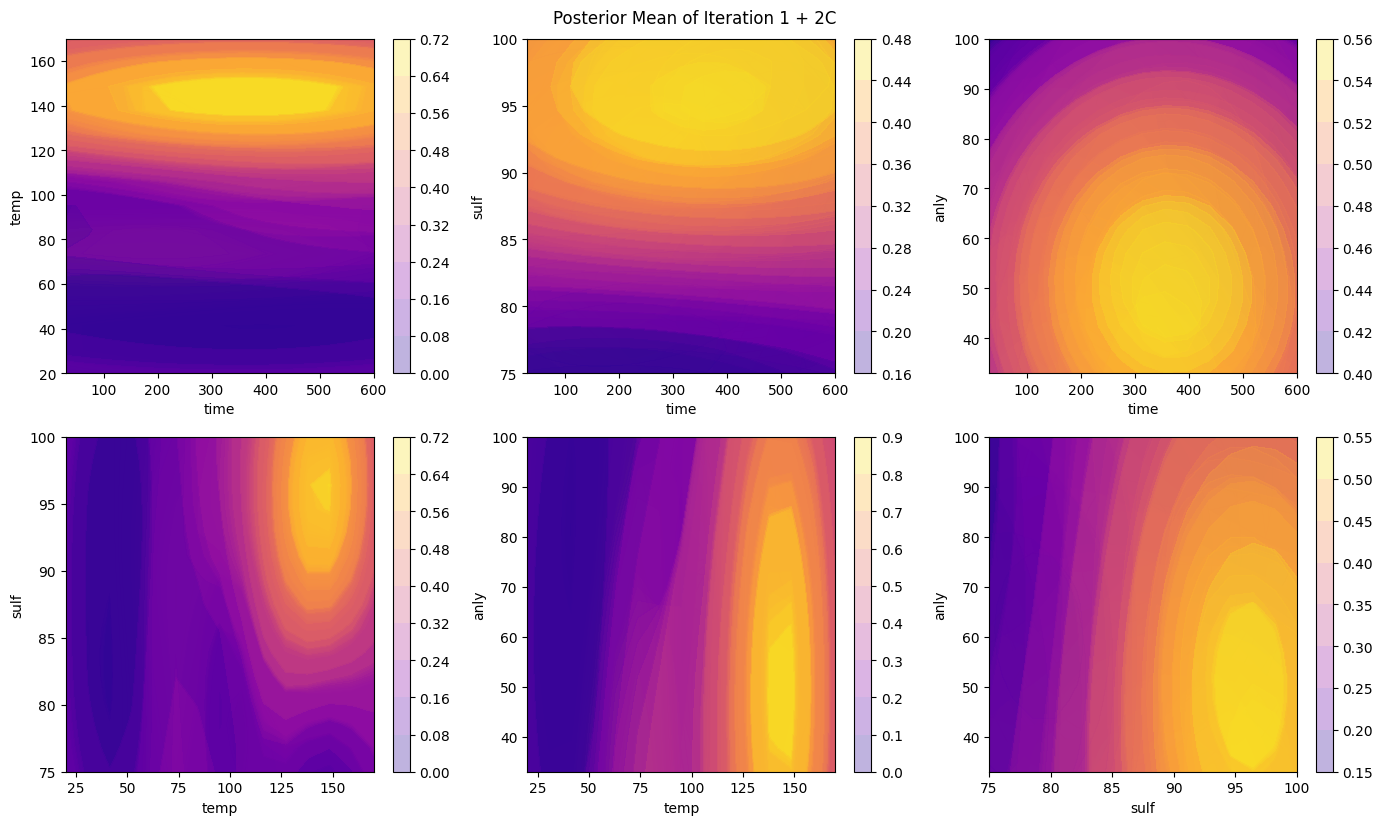

In [171]:
grid_split(mean0,num_points=num_points,A1=A,B2=B,C3=C,D4=D,title="Posterior Mean of Iteration 1 + 2C",cmaps="plasma")

In [172]:
def gpevaluate(model,grid):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(grid)
    mean = posterior.mean
    var = posterior.variance
    return mean, var

# Output

In [173]:
# from PNNL_spectra_extract import data_102119
# #data_102119.head(16)[['time','temp','analyte','yield product']]
# # /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
# # %run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

In [174]:
data_summary = pd.read_csv('data_out.csv')
data_summary.head()

,01_time,01_temp,01_sulf,01_anly,01_yieldproduct,2A_time,2A_temp,2A_sulf,2A_anly,2A_yieldproduct,2B_time,2B_temp,2B_sulf,2B_anly,2B_yieldproduct,2C_time,2C_temp,2C_sulf,2C_anly,2C_yieldproduct
0,49,45,89,84,0.009799,153,104,75,57,0.336757,68,58,85,65,0.415407,132,62,93,90,0.016575
1,49,45,89,84,0.007847,153,104,75,57,0.346431,68,58,85,65,0.276574,132,62,93,90,0.116921
2,49,45,89,84,0.012064,153,104,75,57,0.339406,68,58,85,65,0.349517,132,62,93,90,0.136914
3,87,95,95,97,0.112870,260,104,80,38,0.280879,101,133,85,98,0.572491,144,89,84,57,0.224612
4,87,95,95,97,0.100768,260,104,80,38,0.392731,101,133,85,98,0.441133,144,89,84,57,0.213806


In [175]:
avg_data00 = data_summary.groupby('01_time').mean().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yieldproduct']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yieldproduct':"yield product"})
std_data00 = data_summary.groupby('01_time').std().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yieldproduct']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yieldproduct':"yield product"})

avg_data2C = data_summary.groupby('2C_time').mean().reset_index()[['2C_time','2C_temp','2C_sulf','2C_anly','2C_yieldproduct']].rename(columns = {'2C_time':"time",'2C_temp':"temp",'2C_sulf':"sulf",'2C_anly':"anly",'2C_yieldproduct':"yield product"})
std_data2C = data_summary.groupby('2C_time').std().reset_index()[['2C_time','2C_temp','2C_sulf','2C_anly','2C_yieldproduct']].rename(columns = {'2C_time':"time",'2C_temp':"temp",'2C_sulf':"sulf",'2C_anly':"anly",'2C_yieldproduct':"yield product"})

# Split the data

In [176]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x0 = torch.tensor([avg_data00['time'].to_numpy(),avg_data00['temp'].to_numpy(),avg_data00['sulf'].to_numpy(),avg_data00['anly'].to_numpy()],dtype=torch.float32).T
x0_norm = normalize(x0,bounds)
y0 = torch.tensor(avg_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar0 = torch.tensor(std_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)

x1 = torch.tensor([avg_data2C['time'].to_numpy(),avg_data2C['temp'].to_numpy(),avg_data2C['sulf'].to_numpy(),avg_data2C['anly'].to_numpy()],dtype=torch.float32).T
x1_norm = normalize(x1,bounds)
y1 = torch.tensor(avg_data2C['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar1 = torch.tensor(std_data2C['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)

In [177]:
# Define the ranges for each variable
a_min, a_max = 30, 600 # 30 - 600
b_min, b_max = 20, 170 #30 - 150
c_min, c_max = 75, 100 # 75 - 100
d_min, d_max = 33, 100 # 33- 100

# Number of points in each dimension
num_points = 15

# Generate linspace for each variable
a = torch.linspace(a_min, a_max, num_points)
b = torch.linspace(b_min, b_max, num_points)
c = torch.linspace(c_min, c_max, num_points)
d = torch.linspace(d_min, d_max, num_points)
grid_stack = torch.stack([a,b,c,d],dim = -1)

#grid = torch.stack([a, b, c, d], dim=1)
# Create a meshgrid
A, B, C, D = torch.meshgrid(a,b,c,d, indexing='ij')

# Flatten the grid to get all combinations
grid = torch.stack([A.flatten(), B.flatten(), C.flatten(), D.flatten()], dim=-1)
grid = normalize(grid,bounds)
# Print the shape of the grid
print(grid.shape)  # Should be (num_points**4, 4)

torch.Size([50625, 4])


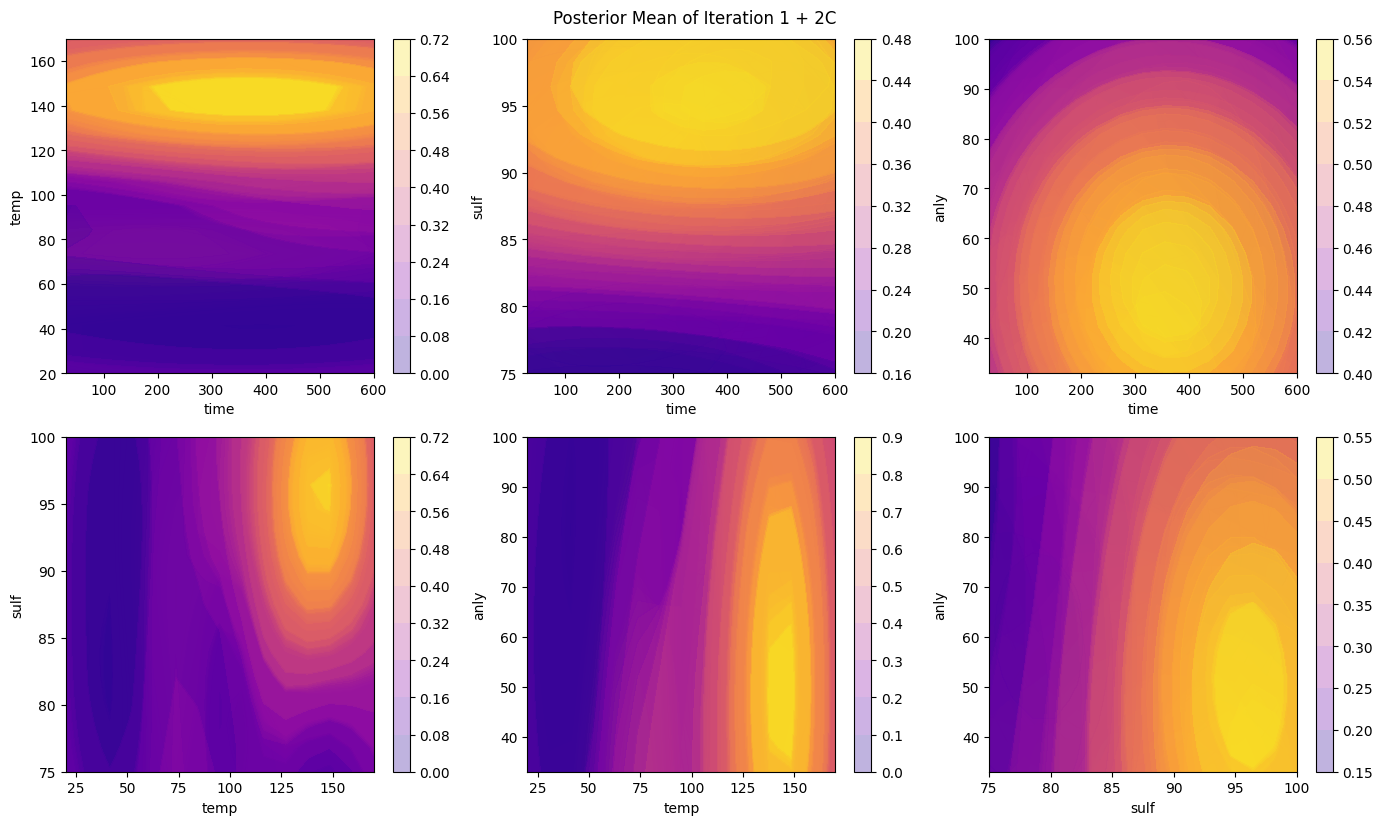

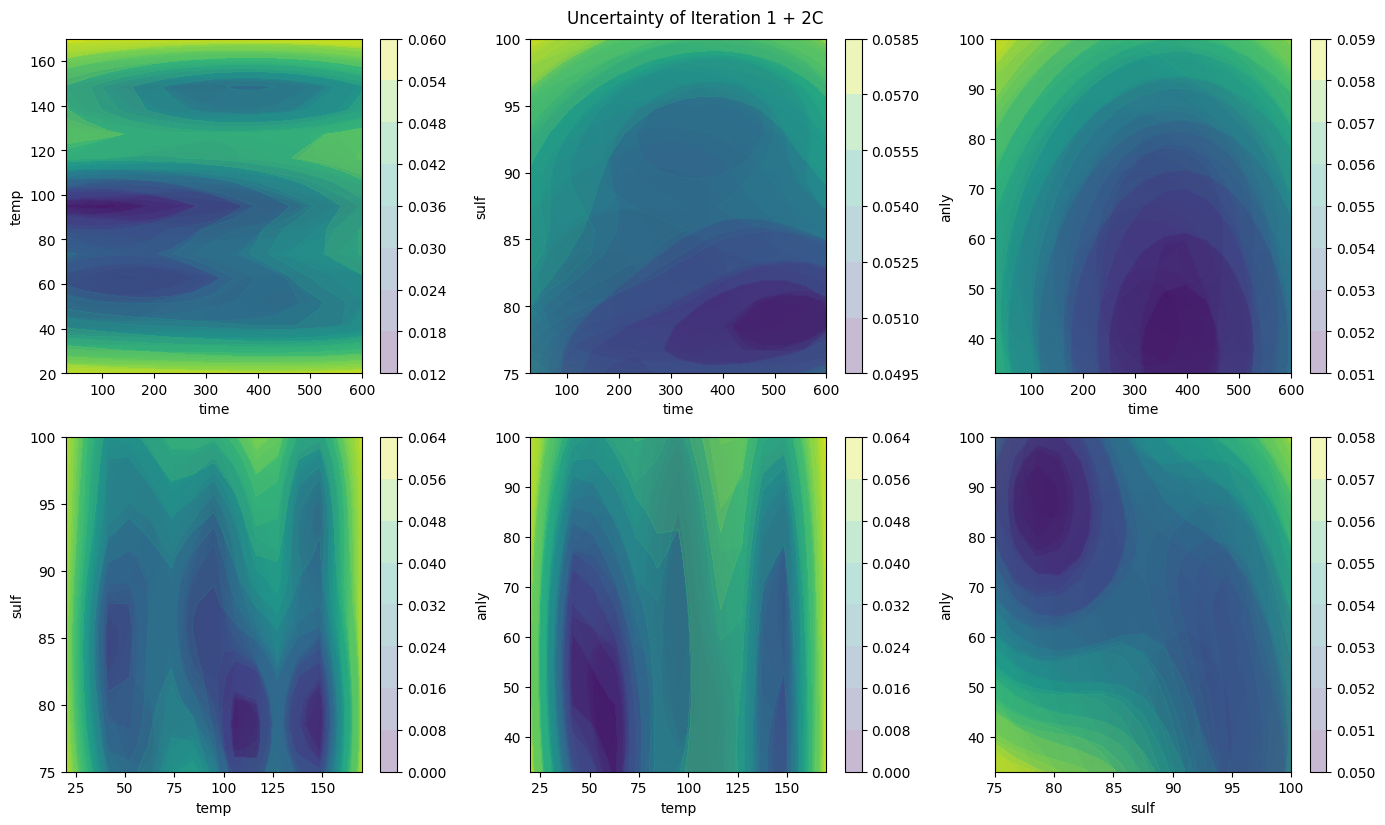

In [178]:
train_x = torch.tensor(torch.vstack([x0_norm,x1_norm]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0,y1]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0,yvar1]), dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll0 = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll0)

mean0,var0 = gpevaluate(gp_model ,grid)

grid_split(mean0,num_points=num_points,A1=A,B2=B,C3=C,D4=D,title="Posterior Mean of Iteration 1 + 2C",cmaps="plasma")
grid_split(var0,num_points=num_points,A1=A,B2=B,C3=C,D4=D,title="Uncertainty of Iteration 1 + 2C",cmaps="viridis")

# 4D BO to determine temps

In [179]:
#bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
#bounds = torch.tensor([[avg_data['time'].min(),avg_data['temp'].min(),avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)
#bounds = torch.tensor([[0,70,100], [80,105,150]], dtype=dtype, device=device)
#bounds = torch.tensor([[0], [150]], dtype=dtype, device=device)
#[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
batch_size = 3 #train_size

# For EI 
best_f = torch.tensor(1.0 ,dtype=dtype) 
target_vector = torch.tensor([1.0],dtype=dtype) # target is 95% or highers

# torch.manual_seed(0)
# mcpoint = torch.rand(15,4)*10
# mcpoint 

In [180]:
train_x = torch.tensor(torch.vstack([x0_norm,x1_norm]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0,y1]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0,yvar1]), dtype=dtype).to(device=device, dtype=dtype)


In [181]:
# Define bounds
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
bound_norm = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],  # Lower bounds for the 3 continuous variables
    [1.0, 1.0,1.0, 1.0]   # Upper bounds for the 3 continuous variables
])

# Set of aquisition functions that can be used for mixed
mc_points = x1

qEI = qExpectedImprovement(model=gp_model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=gp_model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
qPV = qNegIntegratedPosteriorVariance(model=gp_model, mc_points = mc_points) # This does not work for mixed... 

In [182]:
# Generate the conditions <-- BO STEP
acq_funcs = qEI 

candidate2, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bound_norm,
    q=batch_size,
    num_restarts=1,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

print("Centroids of Temperature Clusters:")
centroids = unnormalize(candidate2[:,1],[20,170])
print(centroids.round())

Centroids of Temperature Clusters:
tensor([141., 103., 157.])


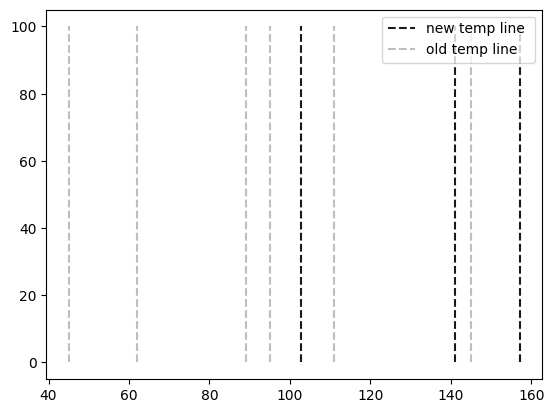

In [183]:
old = [45,95,145,111,62,89]
plt.vlines(centroids,0,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.legend(['new temp line ','old temp line'])

# Mixed BO 4D + temps

In [184]:
# Number of points per dimension
num_points = 15

# Define the ranges for each variable
a_min, a_max = 30, 600 # 30 - 600
b_min, b_max = 30, 150 #30 - 150
c_min, c_max = 75, 100 # 75 - 100
d_min, d_max = 33, 100 # 33- 100

# Generate linspace for each variable
a = torch.linspace(a_min, a_max, num_points)
c = torch.linspace(c_min, c_max, num_points)
d = torch.linspace(d_min, d_max, num_points)

# Generate a list of three distinct values repeated to match 15 points
b_values = centroids.sort().values #torch.tensor([72., 119.,140.]) 
b = b_values.repeat_interleave(num_points // len(b_values))
# If num_points is not a multiple of len(d_values), you'll need to pad or trim
b = torch.cat([b, b_values[:num_points % len(b_values)]]) if num_points % len(b_values) != 0 else b

# Create the meshgrid
A1, B2, C3, D4 = torch.meshgrid(a, b, c, d, indexing='ij')

# Stack and reshape to the required grid shape
grid_mix = torch.stack([A1.flatten(), B2.flatten(), C3.flatten(), D4.flatten()], dim=-1)
grid_mix = normalize(grid_mix,bounds=bounds)
print(grid_mix.shape)  # Should print torch.Size([15, 15, 15, 15, 4])
print(grid_mix)

torch.Size([50625, 4])
tensor([[0.0000, 0.5514, 0.0000, 0.0000],
        [0.0000, 0.5514, 0.0000, 0.0714],
        [0.0000, 0.5514, 0.0000, 0.1429],
        ...,
        [1.0000, 0.9140, 1.0000, 0.8571],
        [1.0000, 0.9140, 1.0000, 0.9286],
        [1.0000, 0.9140, 1.0000, 1.0000]])


In [185]:
# BO parameters for MIXED
batch_size = 15

# Discrete variable choices from 1D BO
discrete_choices= normalize(centroids,[20,170]).numpy().T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]
fixed_features_list


[{1: 0.8070829510688782}, {1: 0.551396906375885}, {1: 0.9139523506164551}]

In [186]:
from botorch.models import MixedSingleTaskGP
model = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

#mean_mix,var_mix = gpevaluate(model,grid_mix)
#mean_mix,var_mix = gpevaluate(model,grid)

ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): MixedSingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
          )
          (raw_outputscale_constraint): Positive()
        )
        (1): ScaleKernel(
          (base_kernel): ProductKernel(
            (kernels): ModuleList(
     

In [187]:
# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
#qPV = qNegIntegratedPosteriorVariance(model=model, mc_points = mcpoints) # This does not work for mixed... 

In [188]:
# Choose aquisition functions
acq_funcs = qEI #qNegIntegratedPosteriorVariance(model=model, mc_points = mcpoints, sampler=None, posterior_transform=None, X_pending=None) # This does not work for mixed...#qPV #qEI

# Re-run the BO for the mixed with constrained temps
candidate1, _ = optimize_acqf_mixed(
    acq_function=acq_funcs,
    bounds=bound_norm,
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)
candidate1_denorm = unnormalize(candidate1,bounds)

In [189]:
time = candidate1_denorm[:,0].round()
temp = candidate1_denorm[:,1].round()
sulf = candidate1_denorm[:,2].round()
anly = candidate1_denorm[:,3].round()

data = {
    'time': time,
    'temp': temp,
    'sulf': sulf,
    'anly': anly
}
df_candidate1 = pd.DataFrame(data)
newx = df_candidate1.to_numpy()
newx

array([[145., 141.,  98.,  44.],
       [428., 141.,  92.,  85.],
       [505., 141.,  75.,  89.],
       [453., 141.,  98.,  82.],
       [431., 141.,  78.,  75.],
       [166., 157.,  77.,  79.],
       [457., 141.,  76.,  60.],
       [394., 157.,  83.,  90.],
       [177., 103.,  78.,  67.],
       [164., 141.,  83.,  98.],
       [201., 157.,  97.,  64.],
       [288., 141.,  93.,  84.],
       [361., 141.,  97.,  52.],
       [469., 103.,  99.,  88.],
       [314., 141.,  76.,  34.]], dtype=float32)

In [190]:
df_candidate1

,time,temp,sulf,anly
0,145.0,141.0,98.0,44.0
1,428.0,141.0,92.0,85.0
2,505.0,141.0,75.0,89.0
3,453.0,141.0,98.0,82.0
4,431.0,141.0,78.0,75.0
5,166.0,157.0,77.0,79.0
6,457.0,141.0,76.0,60.0
7,394.0,157.0,83.0,90.0
8,177.0,103.0,78.0,67.0
9,164.0,141.0,83.0,98.0


Text(0.5, 1.0, '4D - Select 3T - 4D mixed')

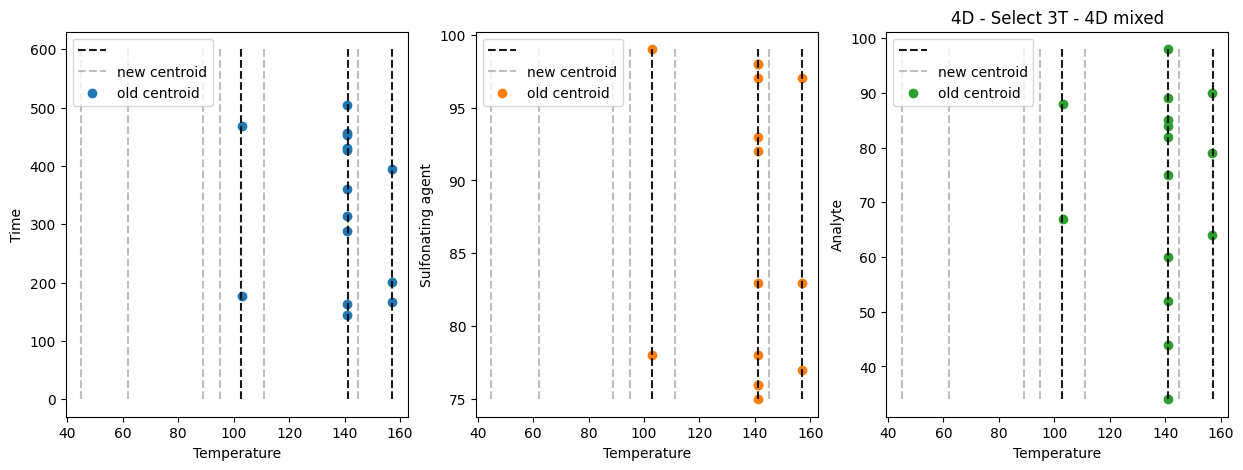

In [191]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,2)
plt.vlines(centroids,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(centroids,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])

plt.title("4D - Select 3T - 4D mixed")



# Plots

In [201]:
# def grid_split_new(mean,num_points,A1,B2,C3,D4,title,new_x,cmaps):
#     mean = mean.reshape(num_points,num_points,num_points,num_points)
#     plt.figure(figsize=(14, 11))
#     plt.subplot(3,3,1)
#     for i in range(num_points):
#         plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,0],new_x[:,1],marker="*",color = "k")
#     plt.xlabel("time")
#     plt.ylabel("temp")

#     plt.subplot(3,3,2)
#     for i in range(num_points):
#         plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,0],new_x[:,2],marker="*",color = "k")
#     plt.xlabel("time")
#     plt.ylabel("sulf")

#     plt.subplot(3,3,3)
#     for i in range(num_points):
#         plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,0],new_x[:,3],marker="*",color = "k")
#     plt.xlabel("time")
#     plt.ylabel("anly")

#     plt.subplot(3,3,4)
#     for i in range(num_points):
#         plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,1],new_x[:,2],marker="*",color = "k")
#     plt.xlabel("temp")
#     plt.ylabel("sulf")

#     plt.subplot(3,3,5)
#     for i in range(num_points):
#         plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,1],new_x[:,3],marker="*",color = "k")
#     plt.xlabel("temp")
#     plt.ylabel("anly")

#     plt.subplot(3,3,6)
#     for i in range(num_points):
#         plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
#     plt.colorbar()
#     plt.scatter(new_x[:,2],new_x[:,3],marker="*",color = "k")
#     plt.xlabel("sulf")
#     plt.ylabel("anly")
    
#     plt.suptitle(title)
#     plt.tight_layout()


def grid_split_new(mean, num_points, A1, B2, C3, D4, title, new_x, cmaps):
    mean = mean.reshape(num_points, num_points, num_points, num_points)
    plt.figure(figsize=(14, 11))

    # Subplot configurations: (x_data, y_data, mean_data, x_label, y_label, new_x indices)
    configs = [
        (A1, B2, mean, "time", "temp", [0, 1], (slice(None), slice(None), 'i', 'i')),
        (A1, C3, mean, "time", "sulf", [0, 2], (slice(None), 'i', slice(None), 'i')),
        (A1, D4, mean, "time", "anly", [0, 3], (slice(None), 'i', 'i', slice(None))),
        (B2, C3, mean, "temp", "sulf", [1, 2], ('i', slice(None), slice(None), 'i')),
        (B2, D4, mean, "temp", "anly", [1, 3], ('i', slice(None), 'i', slice(None))),
        (C3, D4, mean, "sulf", "anly", [2, 3], ('i', 'i', slice(None), slice(None)))
    ]

    # Loop through each configuration to create subplots
    for idx, (x, y, m, xlabel, ylabel, scatter_indices, slices) in enumerate(configs, start=1):
        plt.subplot(3, 3, idx)
        for i in range(num_points):
            # Replace 'i' with the actual loop index in slice tuple
            index_slice = tuple(i if s == 'i' else s for s in slices)
            plt.contourf(x[index_slice], y[index_slice], m[index_slice], alpha=0.3, cmap=cmaps)
        plt.colorbar()
        plt.scatter(new_x[:, scatter_indices[0]], new_x[:, scatter_indices[1]], marker="*", color="k")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    plt.suptitle(title)
    plt.tight_layout()


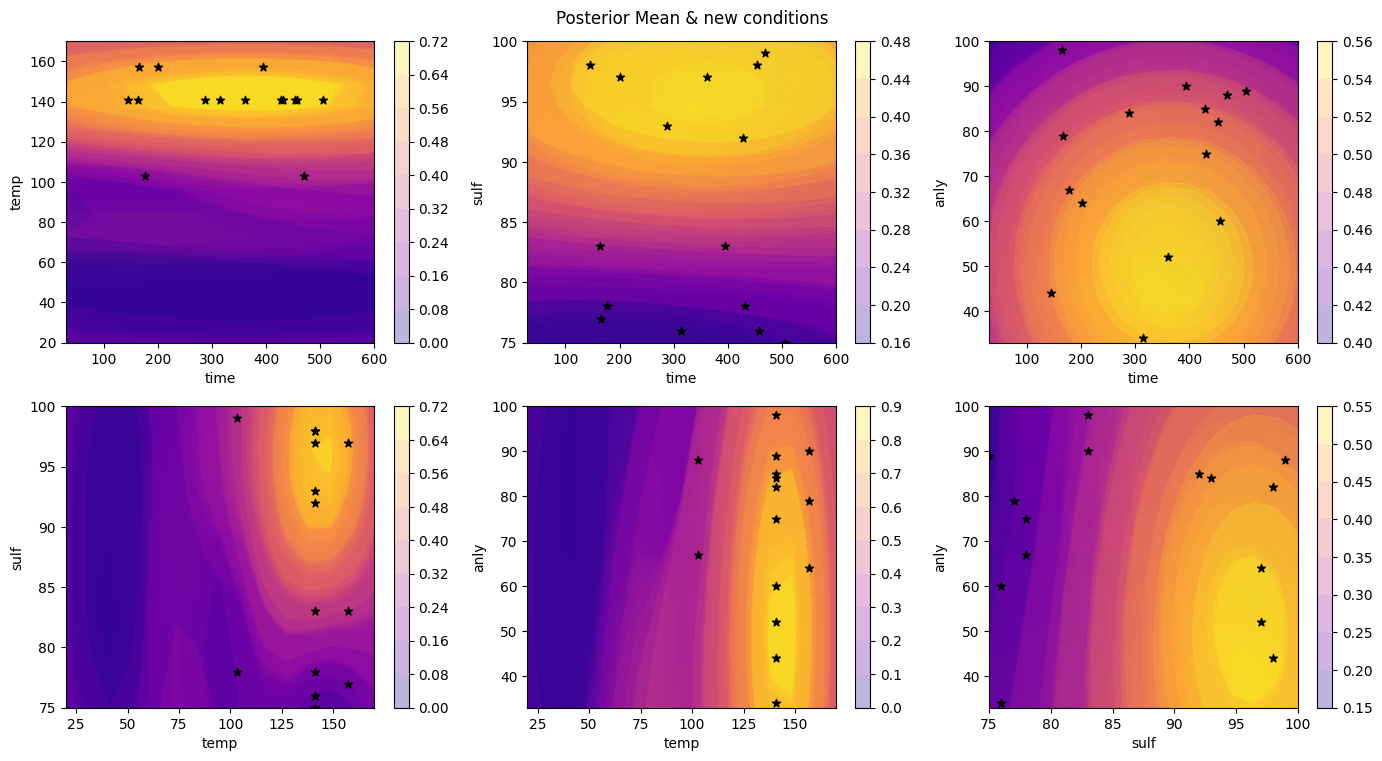

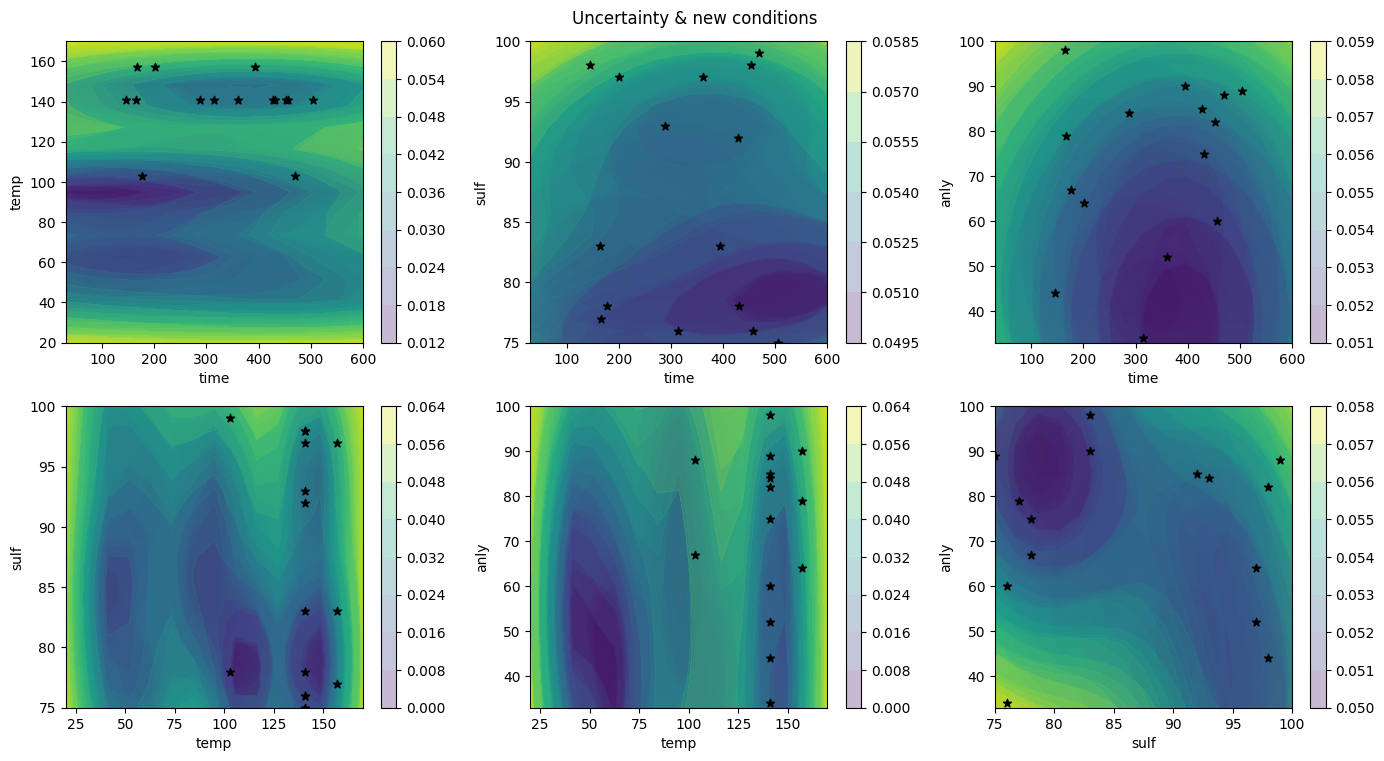

In [202]:
grid_split_new(mean0,num_points=15,A1=A,B2=B,C3=C,D4=D,title="Posterior Mean & new conditions ",new_x=newx,cmaps="plasma")
grid_split_new(var0,num_points=15,A1=A,B2=B,C3=C,D4=D,title="Uncertainty & new conditions",new_x=newx,cmaps="viridis")

In [203]:
# grid_split_new(mean_mix,num_points=num_points,A1=A1,B2=B2,C3=C3,D4=D4,title="mixed GP",new_x=newx)
# grid_split_new(var_mix,num_points=num_points,A1=A1,B2=B2,C3=C3,D4=D4,title="mixed GP",new_x=newx)

In [195]:
#mean_mix,var_mix = gpevaluate(model,torch.tensor(newx))

In [196]:
#scatter_results(torch.tensor(newx),mean_mix,var_mix)
#scatter_results(torch.tensor(newx),mean_mix+var_mix,var_mix)